# 一、问题抽象
## 1. 业务背景
- 某公司海外发行的移动端游戏，近日发现大量来自APPSTORE的退款。
- 查证后发现，AS对于用户的6RMB、18RMB和30RMB充值档位实行无条件退款。
- 黑产大量注册账号，并使用黑信用卡进行充值、退款操作，套取虚拟物品进行转售。
- 同时，因为用户隐私政策，AS不提供充值账号和游戏账号的对应关系。导致虚拟物品无法追回。
- 单日虚拟物品等额损失约12W美金。

## 2. 目标
- 识别黑产刷量账号
- 限制黑产行为
- 控制财产损失

## 3. 难点
- 无明确标识（如何确定正负样本？）
- 无行为信息（如何获取足够特征？）
- 无对应关系（如何关联充值行为？）
- 不能误伤正常用户（如何不侵害正常业务逻辑？）

## 4. 初步方案
- 从业务层进行数据挖掘 --> 获得正负样本
- 对仅有数据进行模式分析 --> 特征工程
- 建立分类模型，利用预测结果对刷量进行二次验证

** 问题抽象环节，核心目的是为业务问题找对解决方向 **

# 二、数据处理
## 1. 可能利用的数据
- 账号
- IP
- UA
- 游戏行为
- 充值行为
### 备注：实际过程中，还需要记得做数据清理

## 2. 正负样本
- 正常用户和刷量之间的差异
- 寻找两者置信的边界
- 宁愿错杀，还是宁愿放过？
- （宁愿放过，原因是：要保障pos的纯度，使之不影响训练的结果）

- 正样本（postive是业务问题的目标）


** 正样本（1） --> 新注册、充值只发生过6\18\30、只发生一笔充值、注册立刻充值、充值后马上进行交易 **

** 负样本（0） --> 找绝对能肯定不是刷量的账号：VIP大户、注册超过一定时间且充值超过一定金额 **

## 3. 样本平衡
- 抽样（抽样有两种，上采样：小变大：下采样：大变小）
- 时间范围
- 目的：尽可能覆盖模式的情况下，减少验证建模的数据量。（时间紧迫啊！没时间处理那么多数据）

In [11]:
import pandas as pd
from itertools import *
from string import ascii_lowercase
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve,roc_auc_score,accuracy_score,precision_score,recall_score,f1_score

In [12]:
# 导入数据，直观感受一下
df = pd.read_csv('data.csv', header=None)

df.columns = ['feature', 'label']

print(df[df['label'] == 0].count())
print(df[df['label'] == 1].count())

feature    43580
label      43580
dtype: int64
feature    50000
label      50000
dtype: int64


# 三、特征工程
## 1. 问题
- 如何构建特征？

## 2. 思路
- 自然人注册账号会使用具有‘意义’的字符
- 人的记忆是习惯顺序的而非倒序和乱序
- 字符的出现具有‘模式’，数字的出现具有‘模式’
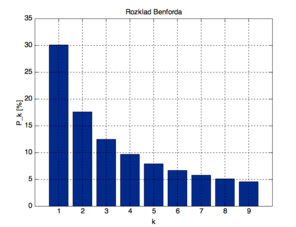
- 刷量注册账号需要考虑成本
- 从统计意义来说，刷量属于一套‘生成模式’
- 从熵的角度来看，刷量比自然人账号的熵要大

- 例子：账号zhangsan中zh这个组合的出现概率，要大于账号xlqixejs中js的出现概率

## 3. 操作
### 建立特征map
- 包含小写字母和数字
- 包含N个字符则为N元

** 补充：可以有多重的拆分，为演示只做二元的拆分 **


In [22]:
# 生成一个字符串，包含所有小写字母和数字
source = ascii_lowercase
for i in range(10):
    source += str(i)
    
# print(source)

# 生成特征map，最终是一个数组
feature_map = []

# for i in permutations(source, 2):
for i in combinations_with_replacement(source, 2):
    feature_map.append(i[0]+i[1])
    
# print(len(feature_map))
print(feature_map)

['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al', 'am', 'an', 'ao', 'ap', 'aq', 'ar', 'as', 'at', 'au', 'av', 'aw', 'ax', 'ay', 'az', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'bb', 'bc', 'bd', 'be', 'bf', 'bg', 'bh', 'bi', 'bj', 'bk', 'bl', 'bm', 'bn', 'bo', 'bp', 'bq', 'br', 'bs', 'bt', 'bu', 'bv', 'bw', 'bx', 'by', 'bz', 'b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'ck', 'cl', 'cm', 'cn', 'co', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'dd', 'de', 'df', 'dg', 'dh', 'di', 'dj', 'dk', 'dl', 'dm', 'dn', 'do', 'dp', 'dq', 'dr', 'ds', 'dt', 'du', 'dv', 'dw', 'dx', 'dy', 'dz', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'ee', 'ef', 'eg', 'eh', 'ei', 'ej', 'ek', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ew', 'ex', 'ey', 'ez', 'e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6

In [24]:
# 对账号进行拆元
def split_acc(acc, num):
    res = []
    for i in range(len(acc)-num+1):
        res.append(acc[i:i+num])
    return res

# split_acc('abcdef', 2)

# 建立向量化特征，它是一个二维数组
vec_feature = []

for f in df['feature']:
    # 先把一个账号字符串拆分成对应元的list
    acc = split_acc(f, 2)
    # 建立一个全0 list，大小为特征长度
    v = [0] * len(feature_map)
    for i,f_m in enumerate(feature_map):
        v[i] = acc.count(f_m)
    vec_feature.append(v)


In [34]:
vec_data = pd.DataFrame(vec_feature)

vec_data['y'] = df['label']

vec_data.to_csv('vec_data.csv')

vec_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,657,658,659,660,661,662,663,664,665,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
vec_data = pd.read_csv('vec_data.csv')

train_x,test_x,train_y,test_y = train_test_split(vec_data.iloc[:,0:665], vec_data['y'], test_size=0.2, random_state=1, stratify=vec_data['y'])

print(train_x.shape)
print(test_x.shape)

(74864, 665)
(18716, 665)


# 四、建模与训练
## 1.选择算法
- 通过经验来选择算法范围
- 经验包括：对特征的敏感、对数据量的把握、对执行效率的控制

## 2.当前情况
- 特征：及其稀疏、是离散特征
- 数据：时效性强、可能需要频繁训练
- 效率：需要在线对业务进行处理

## 3.方案
- 分类任务
- 运行速度快
- 不需要解释性

In [26]:
clf = SGDClassifier(loss='log',max_iter=100,penalty='l2')

model = clf.fit(train_x, train_y)

y_p = model.predict(test_x)
y_s = model.predict_proba(test_x)


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


# 五、模型评估和优化
## 1.从0到1
- 先解决有无问题，评估效果够用则马上上线
- 无论多赶工，还是要做交叉验证

## 2.从大到小
- 若一个算法效果无法达到业务需求，检查无操作错误后，直接换个算法
- 达到基本线，再开始细化调整

## 3.方案
- 增加拆元N值，获得更多的模式信息（空间占用增加）
- 特征交叉（效率变低）
- 用DL发掘更多模式
- 超参数网格搜索，进行超参数微调（耗时）
- 特征值要记得缩放归一化！（LR、SVM、DT都是对特征缩放敏感的算法）

In [27]:
print('accuracy_score: %f' %accuracy_score(test_y,y_p))
print('precision_score: %f' %precision_score(test_y,y_p))
print('recall_score: %f' %recall_score(test_y,y_p))
print('f1_score: %f' %f1_score(test_y,y_p))
print('roc_auc_score: %f' %roc_auc_score(test_y,y_s[:,1]))


accuracy_score: 0.538203
precision_score: 0.536394
recall_score: 1.000000
f1_score: 0.698251
roc_auc_score: 0.504188


** LR各项指标看起来都挺不错，但是我们的问题在于找出刷量，RC的值不太理想 **

In [5]:

SVM = svm.SVC(max_iter=100, probability=True)

svm_model = SVM.fit(train_x, train_y)

svm_y_p = svm_model.predict(test_x)
svm_y_s = svm_model.predict_proba(test_x)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [6]:
print('accuracy_score: %f' %accuracy_score(test_y,svm_y_p))
print('precision_score: %f' %precision_score(test_y,svm_y_p))
print('recall_score: %f' %recall_score(test_y,svm_y_p))
print('f1_score: %f' %f1_score(test_y,svm_y_p))
print('roc_auc_score: %f' %roc_auc_score(test_y,svm_y_s[:,1]))

accuracy_score: 0.999038
precision_score: 0.998203
recall_score: 1.000000
f1_score: 0.999101
roc_auc_score: 0.930378


# 六、模型部署
## 1.模型角度
- 通过PMML转到JAVA环境去执行
## 2.业务角度
- 要放在注册的环节中
- 不能直接拒绝被判别为刷量的用户注册
- 要对当前注册流程无侵害（为什么？因为你更改注册逻辑，比如说增加了验证，那么刷量会随之针对）
- 当账号被判别为刷量，标记当前账号。它可以正常游戏、充值、消费商店物品，但是7天内不让它进行商店物品交易。
## 3.后续处理
- 对整个账号库进行离线判别，所有账号都加入标记，但是不执行操作。
- 对标记的账号进行数据跟踪（保留游戏内行为LOG）
- 增加后续的游戏时长、行为、IP等特征

# 七、结项和汇报
## 1.突发业务问题结项时机
- 项目不能久拖
- 达成初步目标就先做一期结项
## 2.如何汇报
- 汇报不行等于白干
- 对上汇报业务效果
- 对内汇报模型评估数据
- 数据一定要有baseline
## 3.后续
- 突发问题变成晋升资本（将解决方案常态化）
- 项目工程演变成系统（36刷量判别模型 --> 平台账号防刷系统）


# 附录
```python
# 导入字符串处理库
from string import ascii_lowercase

# 组合字母和数字
source = ascii_lowercase
for i in range(10):
    source += str(i)
    
# 凯撒密码
def encrypt(msg, key, source):
    result = ''
    for word in msg:
        num = source.find(word)
        num += key
        if num >= len(source):
            num -= len(source)
        result += source[num]
    return result
```

In [16]:
a = ['a','b','c']

# 这是排列
print('这是排列')
for i in permutations(a, 2):
    print(i)


# 这是组合（with_replacement表示可以重复自身）
print('这是组合')
for k in combinations_with_replacement(a, 2):
    print(k)

这是排列
('a', 'b')
('a', 'c')
('b', 'a')
('b', 'c')
('c', 'a')
('c', 'b')
这是组合
('a', 'a')
('a', 'b')
('a', 'c')
('b', 'b')
('b', 'c')
('c', 'c')
